# Convolutional Neural Networks

Let's learn about convolutional neural networks (CNN). Rather than using linear layers, we mostly use CNN on images. Compared to using linear layers, we can get more accuracy fast because CNN has less parameters to train and can capture patterns easily.


First, we setup environments. For data, we will use MNIST digits.

In [1]:
from torch import tensor, nn
import pickle, gzip, torch, matplotlib as mpl
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Conv1d

Let's go over how Pytroch's convolutional neural networks work. We will start with a simple example, which is `Conv1d`. Let's say we have a vector with shape `(1, 2)`. We can think of this vector as a sentence with two words, like "I sit," and converted numbers into numbers so that computers can understand.

In [5]:
torch.manual_seed(1)
sent1 = torch.randn((1, 2))
sent1

tensor([[0.66, 0.27]])

Here is a `Conv1d` layer with 1 input, 1 output, 2 kernel_size. When we look at the weight of this layer, it is the kernels. Its shape corresponds to `(output, input, kernel_size)`. In this simple case, we have one kernel with size 2 kernel. The shape of bias depends on the output of the layer.

In [6]:
layer1 = nn.Conv1d(1, 1, kernel_size=2)
layer1

Conv1d(1, 1, kernel_size=(2,), stride=(1,))

In [7]:
layer1.weight, layer1.weight.shape

(Parameter containing:
 tensor([[[-0.67,  0.42]]], requires_grad=True),
 torch.Size([1, 1, 2]))

In [8]:
layer1.bias

Parameter containing:
tensor([-0.15], requires_grad=True)

When we apply this layer into our sentence, we get -0.26, which is the same as calculating a dot product of weight and the sentence added by bias.

In [9]:
layer1(sent1)

tensor([[-0.47]], grad_fn=<SqueezeBackward1>)

In [10]:
(layer1.weight * sent1).sum() + layer1.bias

tensor([-0.47], grad_fn=<AddBackward0>)

When we set the output to 2, that means there are two kernels: one for each output. We generally refer to output as channel. So, when we increae the ouput, we say we increase the channel. We will talk about why it would be useful later.

In [11]:
layer2 = nn.Conv1d(1, 2, kernel_size=2)
layer2

Conv1d(1, 2, kernel_size=(2,), stride=(1,))

In [12]:
layer2.weight, layer2.weight.shape

(Parameter containing:
 tensor([[[ 0.36,  0.10]],
 
         [[-0.09,  0.20]]], requires_grad=True),
 torch.Size([2, 1, 2]))

In [13]:
layer2.bias

Parameter containing:
tensor([0.03, 0.26], requires_grad=True)

In [14]:
layer2(sent1)

tensor([[0.30],
        [0.25]], grad_fn=<SqueezeBackward1>)

In [15]:
(layer2.weight[0] * sent1).sum() + layer2.bias[0]

tensor(0.30, grad_fn=<AddBackward0>)

In [16]:
(layer2.weight[1] * sent1).sum() + layer2.bias[1]

tensor(0.25, grad_fn=<AddBackward0>)

That was simple. What if sentence is longer than 2 words? Let's say we have 4 words this time. When we apply `layer1` to it, we get 3 numbers.

In [17]:
sent2 = torch.randn((1, 4))
sent2

tensor([[-1.33,  0.52,  0.75, -0.08]])

In [18]:
layer1(sent2)

tensor([[ 0.96, -0.17, -0.67]], grad_fn=<SqueezeBackward1>)

We can imagine our kernel as a sliding window moving from left to right. That's what `stride` is. By default it is 1, and it moves 1 step by step. This is how it is calculated:

In [19]:
for words in [sent2[0][i:i+2] for i in range(len(sent2[0]) - 1)]:
    print((layer1.weight * words).sum() + layer1.bias)

tensor([0.96], grad_fn=<AddBackward0>)
tensor([-0.17], grad_fn=<AddBackward0>)
tensor([-0.67], grad_fn=<AddBackward0>)


### Stride and Padding

So that's basically how convolution works. By setting different values to stride, we can change how many times the kernel moves each step. By setting stride to 2, we skip some computations.

In [20]:
layer3 = nn.Conv1d(1, 1, kernel_size=2, stride=2)
layer3

Conv1d(1, 1, kernel_size=(2,), stride=(2,))

In [21]:
layer3(sent2)

tensor([[ 0.20, -0.61]], grad_fn=<SqueezeBackward1>)

Because the kernel moved twice each step, it is now instead of 3 values, we have 2 values as an output. This way, we can reduce the number of pixels of the input, which means we can store information more compactly like zipping a file. However, this might actually lose data if we shrink too much. Therefore, we increase the channel of the input when we use stride to balance it out.

For instance, if we use stride 2, we half height and width, which results in 4 times less pixels. By adding a channel, we increase the output by 2 times. Therefore, we only divide the pixel by 2 each layer, which is reasonable for neural net to learn patterns.

What is a padding then? It is a way to put zeroes in the corner. If we put padding as 2, we put 2 zeroes on the left and right of our sentence before applying kernels. Therefore, first and last values are equal to just biases in this example.

In [22]:
sent2

tensor([[-1.33,  0.52,  0.75, -0.08]])

In [23]:
layer4 = nn.Conv1d(1, 1, kernel_size=2, stride=2, padding=2)
layer4

Conv1d(1, 1, kernel_size=(2,), stride=(2,), padding=(2,))

In [24]:
layer4(sent2)

tensor([[0.42, 0.74, 0.25, 0.42]], grad_fn=<SqueezeBackward1>)

In [25]:
layer4.bias

Parameter containing:
tensor([0.42], requires_grad=True)

## Conv2d

We've been using `conv1d`, but conv2d works the same way except we have 2 dimensional kernels instead of 1d, and they also move down.

In [26]:
layer5 = nn.Conv2d(1, 1, kernel_size=2, stride=1, padding=0)
layer5

Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))

In [27]:
layer5.weight.shape, layer5.bias.shape

(torch.Size([1, 1, 2, 2]), torch.Size([1]))

Shape of weight: (Outp, Inp, *Kernel_size)

Shape of bias: Outp

Let's start with a simple example again. Here is a small image with 3 pixel high and 3 pixel wide.

In [28]:
im1 = torch.randn((1, 3, 3))
im1

tensor([[[-0.42, -0.51, -1.57],
         [-0.12,  3.59, -1.83],
         [ 1.60, -1.28,  0.33]]])

In [29]:
im1.shape

torch.Size([1, 3, 3])

In [30]:
layer5(im1), layer5(im1).shape

(tensor([[[ 1.07,  1.96],
          [-1.00,  1.99]]], grad_fn=<SqueezeBackward1>),
 torch.Size([1, 2, 2]))

So, now let's talk about different kernels. Why do we even use kernels? What do they do? So, let's say we have an image of digit 5 from MNIST.

In [31]:
def show_im(im, figsize=None):
    fig, ax = plt.subplots(figsize=figsize)
    if all(hasattr(im, x) for x in ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im)

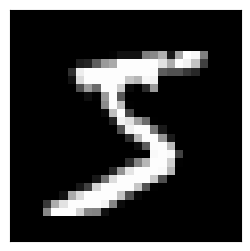

In [32]:
im2 = x_train[0].reshape((1, 28, 28))
show_im(im2, figsize=(3,3))

In [33]:
layer6 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
layer6, layer6.weight.shape

(Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)), torch.Size([1, 1, 3, 3]))

Here is a kernel that detects the top edge. We can apply this kernel to find top edge from an image. Let's see what it looks like.

In [34]:
top_edge = torch.nn.Parameter(tensor([[1,1,1],[0,0,0],[-1,-1,-1]],
                                     dtype=torch.float32).reshape((1, 1, 3, 3)))
top_edge

Parameter containing:
tensor([[[[ 1.,  1.,  1.],
          [ 0.,  0.,  0.],
          [-1., -1., -1.]]]], requires_grad=True)

In [35]:
top_edge.shape

torch.Size([1, 1, 3, 3])

In [36]:
layer6.weight = top_edge
layer6.weight

Parameter containing:
tensor([[[[ 1.,  1.,  1.],
          [ 0.,  0.,  0.],
          [-1., -1., -1.]]]], requires_grad=True)

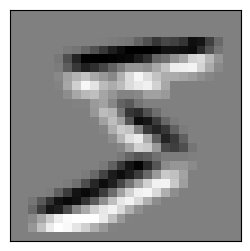

In [37]:
show_im(layer6(im2), figsize=(3,3));

We successfully detected top edge of the image! Let's try to get the right edge.

In [38]:
layer7 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
layer7

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [39]:
right_edge = torch.nn.Parameter(tensor([[-1,0,1],
       [-1,0,1],
       [-1,0,1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0))
right_edge

Parameter containing:
tensor([[[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]]]], requires_grad=True)

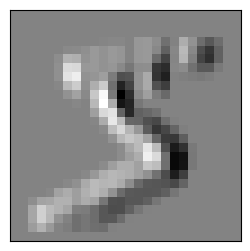

In [40]:
layer7.weight = right_edge
show_im(layer7(im2), figsize=(3,3));

In [68]:
layer00 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
layer00

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [67]:
no_op = torch.nn.Parameter(tensor([[1,1,1],[1,1,1],[1,1,1]],
                                     dtype=torch.float32).reshape((1, 1, 3, 3)))
no_op

Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)

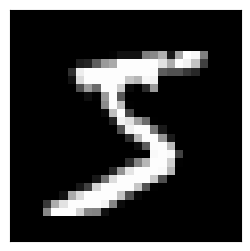

In [71]:
show_im(im2, figsize=(3,3))

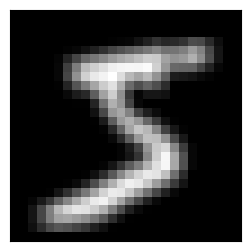

In [69]:
layer00.weight = no_op
show_im(layer00(im2), figsize=(3,3));

Instead of creating two layers, we usually create multiple kernels. `layer8` has two output channels, which means two kernels. We can set these two kernels into what we had, and we can check the output.

In [41]:
layer8 = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=0)
layer8.weight

Parameter containing:
tensor([[[[ 0.16,  0.02,  0.11],
          [ 0.07,  0.12,  0.17],
          [-0.31,  0.17, -0.23]]],


        [[[-0.25,  0.02, -0.06],
          [ 0.20, -0.19, -0.30],
          [ 0.24, -0.05,  0.19]]]], requires_grad=True)

In [42]:
layer8.weight.shape

torch.Size([2, 1, 3, 3])

In [45]:
top_edge.shape

torch.Size([1, 1, 3, 3])

In [51]:
layer8.weight = torch.nn.Parameter(torch.cat([top_edge, right_edge]))
layer8.weight

Parameter containing:
tensor([[[[ 1.,  1.,  1.],
          [ 0.,  0.,  0.],
          [-1., -1., -1.]]],


        [[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]]]], requires_grad=True)

In [62]:
def show_ims(ims, figsize=None):
    fig, ax = plt.subplots(1, len(ims), figsize=figsize)
    for i, im in enumerate(ims):
        if all(hasattr(im, x) for x in ('cpu','permute','detach')):
            im = im.detach().cpu()
            if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
            ax[i].imshow(im)
            ax[i].set_xticks([])
            ax[i].set_yticks([])

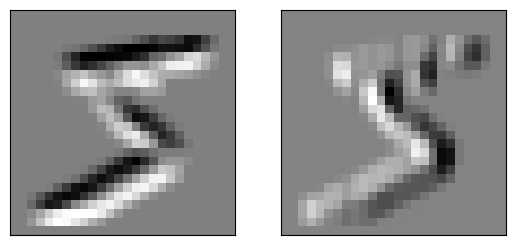

In [63]:
show_ims([im3, im4])

Nice. We got the same output as before.

In [64]:
layer9 = nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=0)
layer9.weight.shape

torch.Size([1, 2, 3, 3])

In [66]:
layer9.weight

Parameter containing:
tensor([[[[ 0.05,  0.06, -0.16],
          [-0.11,  0.08,  0.04],
          [-0.10, -0.07,  0.22]],

         [[-0.04,  0.13,  0.10],
          [-0.15, -0.20,  0.23],
          [ 0.01,  0.16,  0.05]]]], requires_grad=True)

In [72]:
no_op = torch.nn.Parameter(tensor([[1,1,1],[1,1,1],[1,1,1]],
                                     dtype=torch.float32).reshape((3, 3)))
no_op

Parameter containing:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)

In [77]:
torch.stack([no_op, no_op]).unsqueeze(0).shape

torch.Size([1, 2, 3, 3])

In [78]:
no_ops = torch.nn.Parameter(torch.stack([no_op, no_op]).unsqueeze(0))
no_ops

Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)

In [82]:
torch.stack([im3, im4]).shape

torch.Size([2, 26, 26])

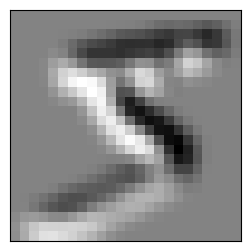

In [86]:
layer9.weight = no_ops
show_im(layer9(torch.stack([im3, im4])), figsize=((3,3)))

So, we combined the output of two images and mixed them into one. In this image, the darkest spots are places where top corner and right corner both happen. This way, the convolutional neural network can combine different features into a more useful one.

## Conclusion

In this blog, we learned how convolutional neural net works by using Pytorch. It is used mostly for images. If you want to learn more, take a look at FastAI [lesson 8](https://course.fast.ai/Lessons/lesson8.html). It might be easier to watch the video to undertstand, and you can come back to play around with the code.

For a challenge, you can try to train MNIST using both linear layers and convolutional neural networks, and try to find out which one is better.